In [5]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

# basic algebra and system libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as path
import pandas as pd
import gc
from tqdm import tqdm
import datetime
import seaborn as sns

# signal discrete fourier transform and loading
import scipy.signal as signal
import scipy.io.wavfile as wavfile
import scipy.fft as fft

# audio preprocessing, cross-validation, and others
from sklearn.base import TransformerMixin, BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score

# construction of convolutional neural network
import keras
import keras.optimizers as optimizers
import keras.layers as layers
import keras.losses as losses
import keras.metrics as metrics
import keras.regularizers as regularizers
from tensorflow.keras import Input
from tensorflow.keras.callbacks import TensorBoard

# audio analysis
import librosa
import librosa.display

# processing speedup using GPU
import tensorflow as tf

# allow GPU computation to exceed system memory for a certain amount
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [6]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [11]:
# Load audio data paths and metadata
metadata = []
data_dir = os.path.join("..", "data", "raw")
class_1_speakers = ['f1', 'f7', 'f8', 'm3', 'm6', 'm8']

for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith(".wav"):
            speaker_id = file.split('_')[0]
            label = 1 if speaker_id in class_1_speakers else 0
            metadata.append({
                'path': os.path.join(root, file),
                'label': label
            })

metadata_df = pd.DataFrame(metadata)
metadata_df.head()
len(metadata)

100

In [12]:
def load_and_split_audio(file_path, target_sr=16000, segment_length=1):
    # Load audio
    audio, sr = librosa.load(file_path, sr=target_sr)
    total_length = len(audio) / sr
    segments = []

    # Split audio into segments of length 'segment_length'
    for start in np.arange(0, total_length, segment_length):
        end = start + segment_length
        segment = audio[int(start*sr):int(end*sr)]
        # Pad if the segment is shorter
        if len(segment) < segment_length * sr:
            segment = np.pad(segment, (0, int(segment_length * sr) - len(segment)), mode='constant')
        segments.append(segment)
    return segments

def generate_spectrograms(segments, sr=16000):
    spectrograms = []
    for segment in segments:
        # Generate Mel Spectrogram
        S = librosa.feature.melspectrogram(y=segment, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
        S_DB = librosa.power_to_db(S, ref=np.max)
        spectrograms.append(S_DB)
    return spectrograms

# Apply load and split
metadata_df['segments'] = [load_and_split_audio(x) for x in tqdm(metadata_df['path'], desc="Loading and Splitting Audio Files")]
metadata_df = metadata_df.explode('segments')

# Generate spectrograms
metadata_df['spectrograms'] = [generate_spectrograms([x])[0] for x in tqdm(metadata_df['segments'], desc="Generating Spectrograms")]

print(f"Total number of spectrograms generated: {len(metadata_df)}")
metadata_df.head()


Generating Spectrograms: 100%|██████████| 16149/16149 [00:46<00:00, 348.38it/s]


Total number of spectrograms generated: 16149


,path,label,segments,spectrograms
0,../data/raw/m2_script5_cleanraw.wav,0,"[-0.00045567978, -0.00087706884, -0.0008387276...","[[-14.655068, -7.2121096, -4.3483057, -2.42628..."
0,../data/raw/m2_script5_cleanraw.wav,0,"[0.00013804888, 0.00010259588, 8.5510925e-05, ...","[[-6.615539, -2.5565867, -5.1238713, -4.038106..."
0,../data/raw/m2_script5_cleanraw.wav,0,"[8.196347e-05, 5.7751036e-05, 3.5946905e-05, 7...","[[-14.558612, -7.051508, -3.2473888, -2.600562..."
0,../data/raw/m2_script5_cleanraw.wav,0,"[-0.0011397437, -0.0011451175, -0.00118782, -0...","[[-10.213371, -7.9638453, -14.317848, -13.1445..."
0,../data/raw/m2_script5_cleanraw.wav,0,"[0.0016269071, 0.0016513073, 0.0016763688, 0.0...","[[-7.71115, -3.4734297, -1.1876097, -3.4024267..."


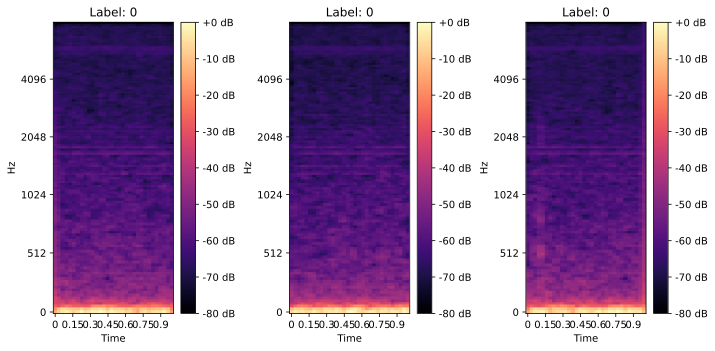

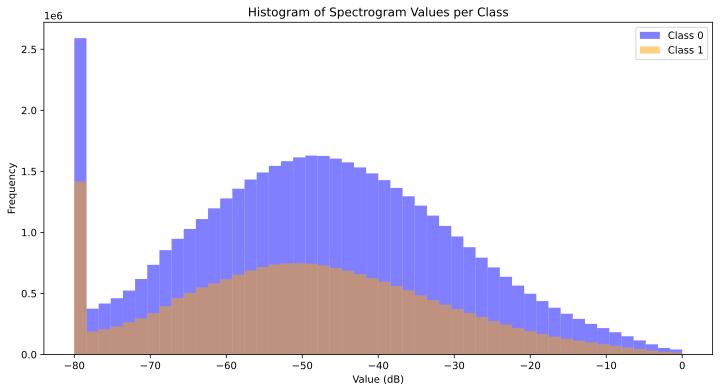

In [13]:
# Plot some example spectrograms
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.subplot(1, 3, i+1)
    librosa.display.specshow(metadata_df.iloc[i]['spectrograms'], sr=16000, hop_length=512, x_axis='time', y_axis='mel')
    plt.title(f"Label: {metadata_df.iloc[i]['label']}")
    plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

# Histogram of spectrogram values per class
class_0_spectrograms = metadata_df[metadata_df['label'] == 0]['spectrograms'].values
class_1_spectrograms = metadata_df[metadata_df['label'] == 1]['spectrograms'].values

# Flatten spectrogram values
class_0_values = np.concatenate([s.ravel() for s in class_0_spectrograms])
class_1_values = np.concatenate([s.ravel() for s in class_1_spectrograms])

# Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(class_0_values, bins=50, alpha=0.5, label='Class 0', color='blue')
plt.hist(class_1_values, bins=50, alpha=0.5, label='Class 1', color='orange')
plt.title("Histogram of Spectrogram Values per Class")
plt.xlabel("Value (dB)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [14]:
X = np.stack(metadata_df['spectrograms'].values)
X = X[..., np.newaxis]  # Add channel dimension for CNN
Y = metadata_df['label'].values

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Create basic CNN model
def create_cnn():
    inputs = Input(shape=(128, 32, 1))
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_cnn()

# Set up TensorBoard callback
log_dir = os.path.join("logs", "fit") + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train model
history = model.fit(
    X_train, Y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, Y_test),
    callbacks=[tensorboard_callback],
    class_weight=dict(enumerate(compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train)))
)

Epoch 1/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step - accuracy: 0.6032 - loss: 0.8166 - val_accuracy: 0.7926 - val_loss: 0.4549
Epoch 2/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 24s 59ms/step - accuracy: 0.8009 - loss: 0.4206 - val_accuracy: 0.8885 - val_loss: 0.2715
Epoch 3/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 24s 60ms/step - accuracy: 0.8703 - loss: 0.2885 - val_accuracy: 0.9099 - val_loss: 0.2176
Epoch 4/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 23s 57ms/step - accuracy: 0.9147 - loss: 0.1922 - val_accuracy: 0.9319 - val_loss: 0.1687
Epoch 5/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.9455 - loss: 0.1391 - val_accuracy: 0.9133 - val_loss: 0.1936
Epoch 6/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - accuracy: 0.9543 - loss: 0.1152 - val_accuracy: 0.9474 - val_loss: 0.1253
Epoch 7/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 24s 60ms/step - accuracy: 0.9657 - loss: 0.0821 - val_accuracy: 0.9563 - val_loss: 0.1045
Epoch 8/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - accuracy: 0.9760 - loss: 0.0672 - 

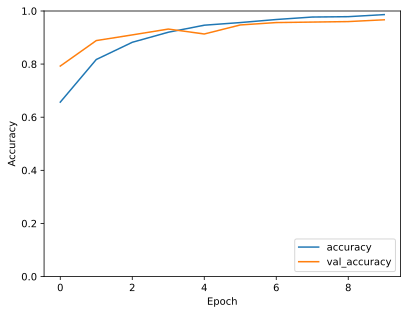

In [15]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [16]:
# Generate predictions and calculate metrics
Y_pred = (model.predict(X_test) > 0.5).astype('int32')

# Calculate accuracy
accuracy = accuracy_score(Y_test, Y_pred)

# Compute the macro-average F1 score
macro_f1 = f1_score(Y_test, Y_pred, average='macro')

# Calculate precision and recall
precision = precision_score(Y_test, Y_pred, average='macro')
recall = recall_score(Y_test, Y_pred, average='macro')

# Output the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Macro F1: {macro_f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

# Show class report
class_report = classification_report(Y_test, Y_pred)
print(class_report)

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Accuracy: 0.9669
Macro F1: 0.9613
Precision: 0.9597
Recall: 0.9630
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2233
           1       0.94      0.95      0.95       997

    accuracy                           0.97      3230
   macro avg       0.96      0.96      0.96      3230
weighted avg       0.97      0.97      0.97      3230



{'f3', 'm1', 'f10', 'm2', 'f5', 'm8', 'm4', 'f9', 'm7'}


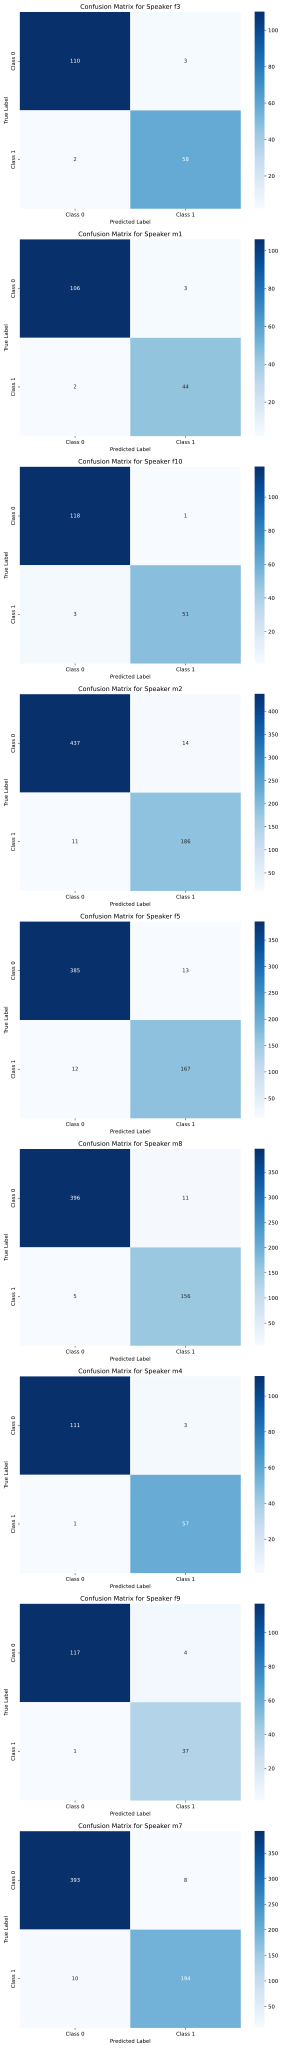

In [17]:
speakers = [os.path.basename(metadata_df['path'].iloc[i]).split('_')[0] for i in range(len(X_test))]
Y_pred_df = pd.DataFrame(Y_pred, columns=['Predictions'])
Y_pred_df['True_Labels'] = Y_test

unique_speakers = set(speakers)
print(unique_speakers)

fig, axes = plt.subplots(len(unique_speakers), 1, figsize=(8, 6 * len(unique_speakers)), squeeze=False)

for i, speaker in enumerate(unique_speakers):
    speaker_indices = [j for j, spk in enumerate(speakers) if spk == speaker]

    if not speaker_indices:
        print(f"No samples found for speaker {speaker}. Skipping...")
        continue

    # Extract true labels and predictions for the current speaker using the indices
    Y_test_speaker = Y_pred_df['True_Labels'].iloc[speaker_indices].values
    Y_pred_speaker = Y_pred_df['Predictions'].iloc[speaker_indices].values

    # Compute confusion matrix
    conf_matrix = confusion_matrix(Y_test_speaker, Y_pred_speaker)

    # Plot confusion matrix
    ax = axes[i, 0]
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Class 0', 'Class 1'],
                yticklabels=['Class 0', 'Class 1'], ax=ax)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title(f'Confusion Matrix for Speaker {speaker}')

plt.tight_layout()
plt.show()


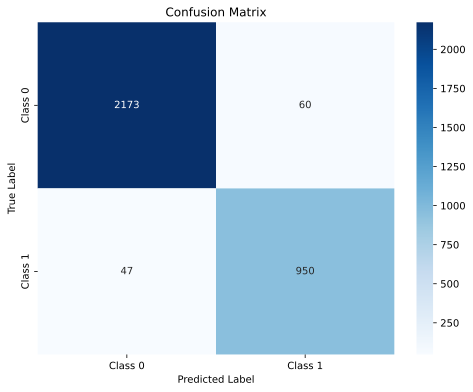

In [18]:
# Plot combined confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# Extract missed examples
misclassified_indices = np.where(Y_test != Y_pred.flatten())[0]

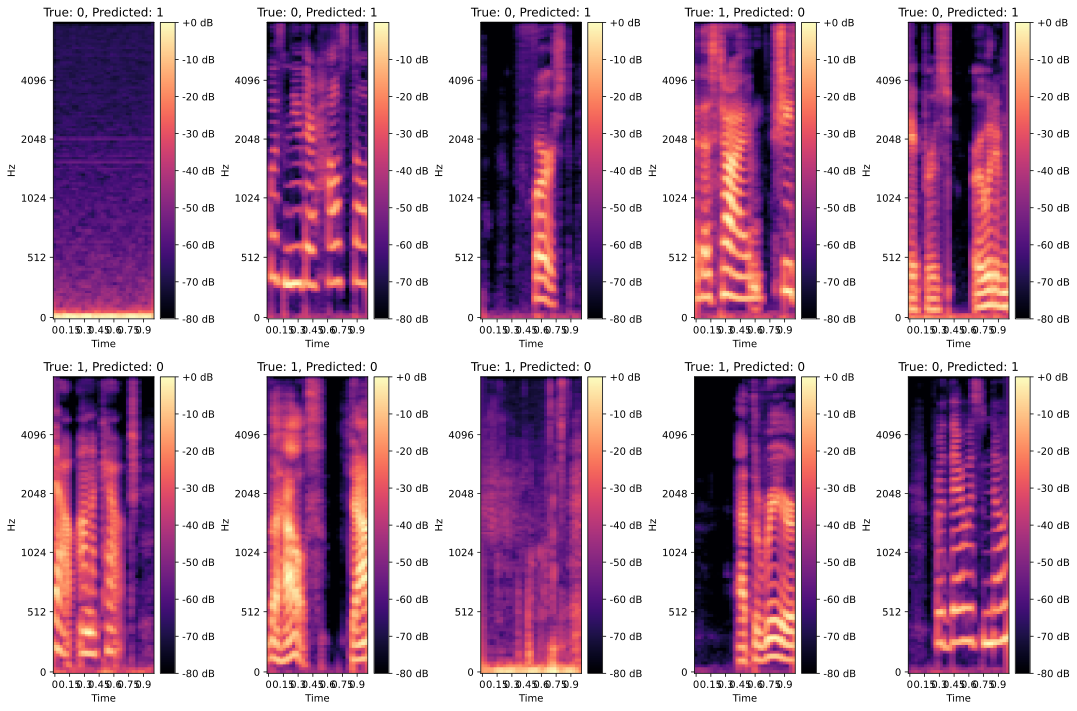

In [20]:
# Plot some misclassified spectrograms
num_to_plot = min(10, len(misclassified_indices))  # Adjust the number to plot as needed
plt.figure(figsize=(15, 10))

for i in range(num_to_plot):
    idx = misclassified_indices[i]
    spectrogram = X_test[idx].squeeze()  # Remove channel dimension

    plt.subplot(2, 5, i + 1)  # Plot in a 2x5 grid for 10 samples
    librosa.display.specshow(spectrogram, sr=16000, hop_length=512, x_axis='time', y_axis='mel')
    plt.title(f"True: {Y_test[idx]}, Predicted: {Y_pred[idx][0]}")
    plt.colorbar(format="%+2.0f dB")

plt.tight_layout()
plt.show()

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


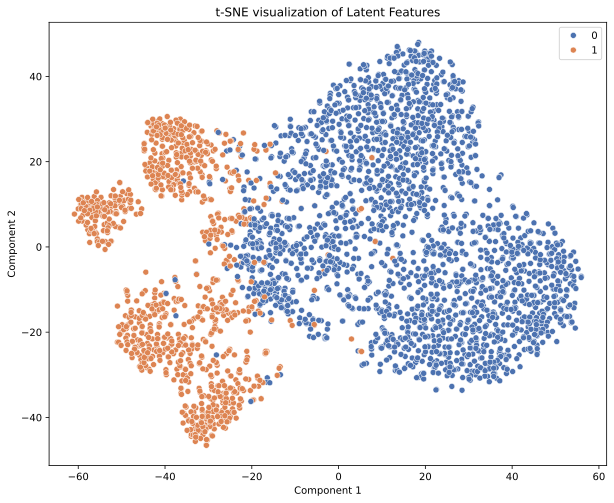

In [21]:
from sklearn.manifold import TSNE
import seaborn as sns

# Extract the penultimate layer activations
intermediate_model = keras.Model(inputs=model.input, outputs=model.layers[-2].output)
latent_features = intermediate_model.predict(X_test)

# Reduce dimensionality to 2D using TSNE
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_features)

# Plot TSNE results
plt.figure(figsize=(10, 8))
sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=Y_test, palette='deep')
plt.title('t-SNE visualization of Latent Features')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


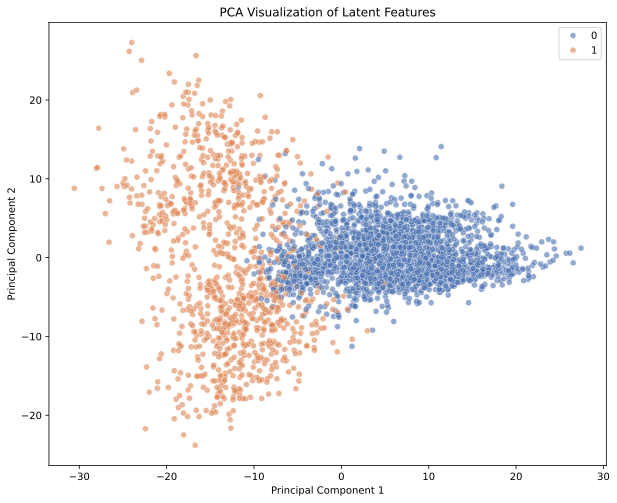

In [22]:
from sklearn.decomposition import PCA

# Step 1: Extract the penultimate layer activations (latent features)
intermediate_model = keras.Model(inputs=model.input, outputs=model.layers[-2].output)
latent_features = intermediate_model.predict(X_test)

# Step 2: Apply PCA to reduce the latent features to 2 dimensions
pca = PCA(n_components=2)
latent_2d_pca = pca.fit_transform(latent_features)

# Step 3: Plot the PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(x=latent_2d_pca[:, 0], y=latent_2d_pca[:, 1], hue=Y_test, palette='deep', alpha=0.6)
plt.title('PCA Visualization of Latent Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

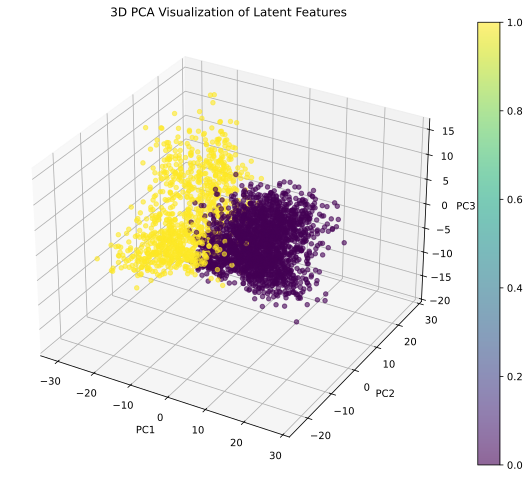

In [23]:
from mpl_toolkits.mplot3d import Axes3D

pca_3d = PCA(n_components=3)
latent_3d_pca = pca_3d.fit_transform(latent_features)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(latent_3d_pca[:, 0], latent_3d_pca[:, 1], latent_3d_pca[:, 2], c=Y_test, cmap='viridis', alpha=0.6)
ax.set_title('3D PCA Visualization of Latent Features')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.colorbar(scatter)
plt.show()